In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix, hstack, vstack, linalg
import numpy.matlib
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
import Q2Q1FEM
import Q2Q1OPT
import PolyFEM
import time

In [2]:
nelx=48
nely=32
left,right,wid,spa = 5/6,5/6,1/6,1/3
Node,Element,NodeBC = Q2Q1OPT.TwoSquareMeshQ2(nelx,nely,left,right,wid,spa)
Node_P,Element_P,NodeBC_P = Q2Q1OPT.TwoSquareMeshQ1(nelx,nely,left,right,wid,spa)
Node_poly,Element_poly,NodeBC_poly = Q2Q1OPT.PolyTwoSquareMeshQ1(nelx,nely,left,right,wid,spa)
fem_NElem = Element.shape[0]
fem_NElem_P = Element.shape[0]
Volfrac = 1/3
zIni = np.ones(fem_NElem)*Volfrac

In [3]:
for iIni in range(nelx*nely):
    x,y = Node[Element[iIni,0],:]+(0.5/nely)
    if (x-0.75)**2+(y-0.75)**2<=0.03:
        zIni[iIni]=0
    elif (x-0.5)**2+(y-0.25)**2<=0.03:
        zIni[iIni]=0
    elif (x-1)**2+(y-0.25)**2<=0.03:
        zIni[iIni]=0

In [4]:
fem_mu0 = 1               # Dynamic viscosity
fem_Reg = 0               # Tag for regular meshes
R = -1
P_ori = np.identity(fem_NElem)
P_ori_P = np.identity(fem_NElem_P)
P = csr_matrix(P_ori)
P_P = csr_matrix(P_ori_P)   
opt_zMin=0.0    # Lower bound for design variables
opt_zMax=1.0    # Upper bound for design variables
opt_zIni = zIni # Initial design variables
opt_zIni_P = zIni
opt_P = P       # Matrix that maps design to element vars.
opt_P_P = P_P
opt_VolFrac = Volfrac  # Specified volume fraction cosntraint
opt_Tol = 0.01   # Convergence tolerance on design vars.
opt_MaxIter = 150  # Max. number of optimization iterations
opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme
q = [0.05,0.1,1]

----- 1 -----
Obj 100.05936921754416 frac 0.3333389530253872
Obj 70.66190857571694 frac 0.33332502896312094
Obj 59.719469063506374 frac 0.33333335088318644
Obj 49.08623400865322 frac 0.3333290718942217
Obj 37.58424676429544 frac 0.33334285822530685


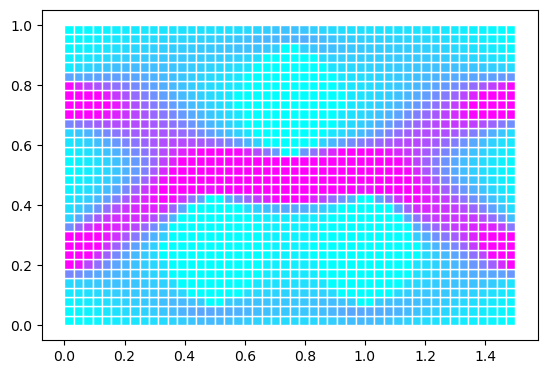

Obj 26.756133738008746 frac 0.3333427058843033
Obj 17.93126614061666 frac 0.3333259533755893
Obj 13.433831091931212 frac 0.3333377978767149


In [ ]:
obj = []
frac = []
z=opt_zIni
iteration = 0
start = time.time()
for i in range(3):
    print('-----',i+1,'-----')
    Tol=opt_Tol*(opt_zMax-opt_zMin)
    Change=2*Tol
    z_P = opt_zIni_P
    P=opt_P
    P_P = opt_P_P
    E,dEdy,V,dVdy = Q2Q1OPT.MatIntFnc(P*z,np.array([fem_mu0,q[i]]))
    E_P,dEdy_P,V_P,dVdy_P = Q2Q1OPT.MatIntFnc(P_P*z_P,np.array([fem_mu0,q[i]]))
    Iter = 0
    while (Iter<opt_MaxIter) and Change>Tol:
        Iter += 1
        iteration +=1
        g,dgdE,dgdV,fem_ElemArea = Q2Q1OPT.ConstraintFncQ2(fem_NElem,Node,Element,E,V,Volfrac)
        f,dfdE,dfdV = Q2Q1OPT.ObjectiveFnc(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,zIni,fem_ElemArea,E,V)
        dfdz = P.T*(np.multiply(dEdy,dfdE)+np.multiply(dVdy,dfdV))
        dgdz = P.T*(np.multiply(dEdy,dgdE)+np.multiply(dVdy,dgdV))
        z,Change = Q2Q1OPT.UpdateScheme(dfdz,g,dgdz,z,opt_zMin,opt_zMax,opt_OCMove,opt_OCEta)
        E,dEdy,V,dVdy = Q2Q1OPT.MatIntFnc(P*z,np.array([fem_mu0,q[i]]))
        #p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_poly,Element_poly,NodeBC_poly,z)
        print('Obj',f*1000,'frac',z.sum()/fem_NElem)
        obj.append(f*1000)
        frac.append(z.sum()/fem_NElem)
        if Iter%5==0:
            Q2Q1OPT.Plot_patch(nely,Node_P,Element_P,z,1,0,cmap='cool')
    Q2Q1OPT.Plot_patch(nely,Node_P,Element_P,z,1,0,cmap='cool')
end = time.time()

In [ ]:
Q2Q1FEM.Plot_patch(nely,Node_P,Element_P,z,1,0,cmap='cool')
print(f_new_poly)
print(sum(z)/fem_NElem)
print(iteration)
print(end-start)

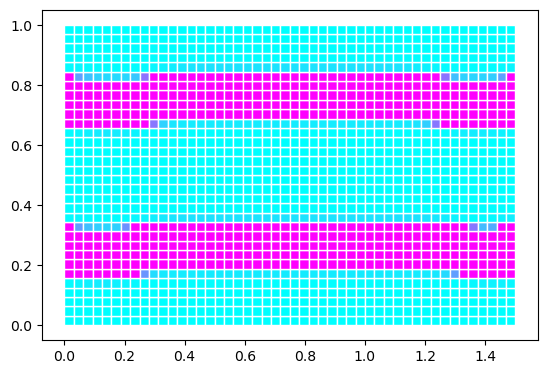

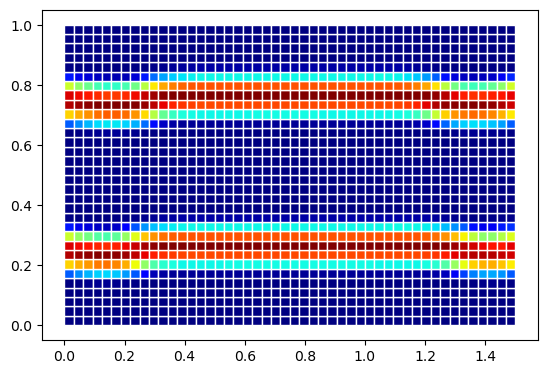

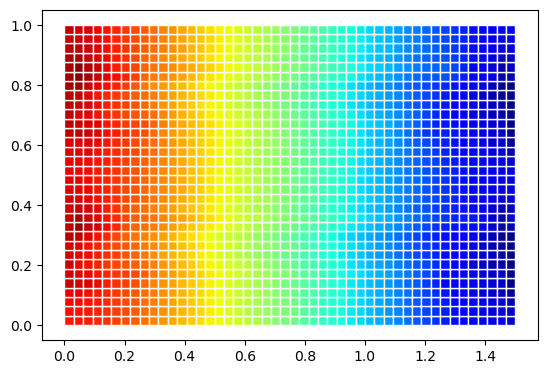

In [29]:
p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z) #original
Q2Q1FEM.Plot_patch(nely,Node_P,Element_P,z,1,0,cmap='cool')
Q2Q1FEM.Plot_patch(nely,Node_P,Element_P,(np.sqrt(u**2+v**2)),1,0,cmap='jet')
Q2Q1FEM.Plot_patch(nely,Node_P,Element_P,p,max(p),min(p),cmap='jet')

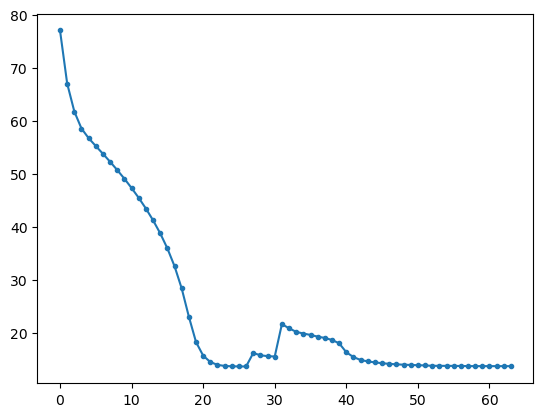

In [28]:
plt.plot(obj,marker='.')